# Table of Content

## Section 1: Data Cleaning and EDA

## Section 2 : Alternating Least Square RecSys Model

## Section 3 : LightFM RecSys Model

## Section 4 : TuriCreate RecSys Model

## Section 5 : RecSys with De

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from pandas.api.types import CategoricalDtype
import warnings
warnings.filterwarnings('ignore')
#pd.options.plotting.backend = 'plotly'

###################################################
import scipy.sparse as sparse
import random
import implicit
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

########################################################
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from itertools import islice


# Section 1

 - Creating proper dataset from different data files
 
         - getting items information from "Materials data" files
         
         - which will be joined with the info from the "Transaction data" files 
         
         - and each item catergory will be extracted from the "rpg_wgh" data files 
 
 
 - Expository Data Analysis
 
         - Numerial Distribution of Data
         
         - Data visualization 
         

### Creating proper dataset from different data files

### Material Data file

   - Data containing item_ids and vendor_ids with subcatergory codes

In [363]:
            #loading the item/material data files...
material_df = pd.read_csv('materials.csv')
material_df.head()

,material,net_weight,rpa_wgh1,rpa_wgh2,rpa_wgh3,rpa_wgh4,unit_of_wt,vendor
0,159121,136.0,FOOD,45.0,4505.0,450503.0,G,104603
1,159122,30.0,NONFOOD,64.0,6401.0,640109.0,G,112359
2,159123,610.0,NONFOOD,74.0,7404.0,740401.0,G,103894
3,159124,42.0,NONFOOD,64.0,6401.0,640111.0,G,104292
4,159125,1200.0,NONFOOD,74.0,7404.0,740401.0,G,103894


In [719]:
            #material dataset columns...
material_df.columns

Index(['material', 'net_weight', 'rpa_wgh1', 'rpa_wgh2', 'rpa_wgh3',
       'rpa_wgh4', 'unit_of_wt', 'vendor'],
      dtype='object')

In [178]:
                                                             #Dataset Information Table for each colum
Data_Dict=pd.DataFrame(material_df.dtypes)                   #datatype of each column
Data_Dict['Missing Val'] = material_df.isnull().sum()        #num of missing values, add to table
Data_Dict['% Missing val'] = round((Data_Dict['Missing Val'].astype(int)/material_df.shape[0] * 100),2)
Data_Dict['Num of Zeros'] = (material_df == 0).sum(0)
Data_Dict['% Num of Zeros'] = round((Data_Dict['Num of Zeros'].astype(int)/material_df.shape[0] * 100),2)
Data_Dict['nUnique Values']=material_df.nunique()            #num of unique entries, add to table
Data_Dict=Data_Dict.rename(columns={0:'Datatype'})
print('The Table below shows the Data Information of each column ')
Data_Dict

The Table below shows the Data Information of each column 


,Datatype,Missing Val,% Missing val,Num of Zeros,% Num of Zeros,nUnique Values
material,object,6,0.00,9,0.00,503613
net_weight,float64,0,0.00,176053,31.94,7519
rpa_wgh1,object,58643,10.64,0,0.00,3
rpa_wgh2,float64,58643,10.64,9,0.00,78
rpa_wgh3,float64,58643,10.64,0,0.00,624
rpa_wgh4,float64,57901,10.51,0,0.00,4674
unit_of_wt,object,57921,10.51,0,0.00,2
vendor,object,130565,23.69,0,0.00,12996


In [179]:
material_df['rpa_wgh1'].unique()

array(['FOOD', 'NONFOOD', 'NONSALES', nan], dtype=object)

In [180]:
material_df['unit_of_wt'].unique()

array(['G', 'KG', nan], dtype=object)

### Weight Data Files :

   - Data files containing item's sub-catergories codes and codes

In [244]:
                 #loading in raw "rpa_wgh2" ....
rpa_wgh2 = pd.read_csv('rpa_wgh2.csv', sep='delimiter', header=None)
rpa_wgh2.head()

,0
0,groupcode;engname
1,01;Canteen
2,02;Cafeteria
3,10;Raw materials
4,11;Fresh meat


In [521]:
wgh2_columns[0]

['groupcode', 'engname']

In [245]:
                #1st row showing the different columns     
                #splitting  each string values in separate columns...
wgh2_columns = rpa_wgh2.loc[:0][0].str.split(';').to_list()  
print("Colum_names: ", wgh2_columns[0])

rpa_wgh2 = rpa_wgh2.drop(rpa_wgh2.index[[0]])
weight_2 =  pd.DataFrame(rpa_wgh2[0].str.split(';').tolist(),
                  columns = wgh2_columns[0])

weight_2.head()

Colum_names:  ['groupcode', 'engname']


,groupcode,engname
0,01,Canteen
1,02,Cafeteria
2,10,Raw materials
3,11,Fresh meat
4,12,Fresh poultry


In [356]:
            #getting unique group codes
weight_2['groupcode'].nunique()

array(['01', '02', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51',
       '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62',
       '63', '64', '65', '66', '67', '69', '72', '73', '74', '96', '97',
       '98', '99'], dtype=object)

In [523]:
           #viewing unique catergory names 
weight_2['engname'].unique()

array(['Canteen', 'Cafeteria', 'Raw materials', 'Fresh meat',
       'Fresh poultry', 'Fresh and processed fish products',
       'Own production culinary products', 'Vegetables',
       'Own production bakery', 'Commercial production bakery', 'Fruits',
       'Natural flowers (cut)', 'Frozen meat', 'Frozen poultry',
       'Frozen fish and seafood',
       'Frozen semi-finished and other products',
       'Processed meat products', 'Dairy products and delicatessen',
       'Spirits', 'Wine', 'Beer and low alcohol beverages', 'Cheese',
       'Fish and seafood delicatessen', 'Nonalcoholic beverages',
       'Chocolate confectionary', 'Coffee, cocoa, tea', 'Functional food',
       'Grocery', 'Condiments, spices, dressings', 'Canned food',
       'Baby food', 'Cosmetics, perfume, hygiene, pharmaceuticals',
       '"Household cleaning products "', 'Tobacco', 'Pet goods', 'Snacks',
       'Baby hygiena', 'Non chocolate Confectionery',
       'Professional pet goods',
       'Mayonnaise, S

In [252]:
                #loading in raw "rpa_wgh3"....
rpa_wgh3 = pd.read_csv('rpa_wgh3.csv', sep='delimiter', header=None)
rpa_wgh3.head()

,0
0,categorycode;engname
1,0101;Business lunch
2,0201;Nonalcoholic beverages (Cafeteria)
3,0202;Freshly squeezed juices (Cafeteria)
4,0203;Hot drinks (Cafeteria)


In [253]:
                   #1st row showing the different columns
                   #splitting  each string values in separate columns...
wgh3_columns = rpa_wgh3.loc[:0][0].str.split(';').to_list()  
print("Colum_names: ", wgh3_columns[0])

rpa_wgh3 = rpa_wgh3.drop(rpa_wgh3.index[[0]])
weight_3 =  pd.DataFrame(rpa_wgh3[0].str.split(';').tolist(),
                  columns = wgh3_columns[0])

weight_3.head()

Colum_names:  ['categorycode', 'engname']


,categorycode,engname
0,0101,Business lunch
1,0201,Nonalcoholic beverages (Cafeteria)
2,0202,Freshly squeezed juices (Cafeteria)
3,0203,Hot drinks (Cafeteria)
4,0204,Shakes (Cafeteria)


In [365]:
weight_3.nunique()

categorycode    463
engname         462
dtype: int64

In [295]:
                    #loading in raw "rpa_wgh4"....
rpa_wgh4 = pd.read_csv('rpa_wgh4.csv', sep='delimiter', header=None)
rpa_wgh4.head()

,0
0,subcategorycode;engname;Class
1,010101;Office Business lunch;FOOD
2,010102;Store Business lunch;FOOD
3,020101;Juices (Cafeteria);FOOD
4,020102;Water (Cafeteria);FOOD


In [296]:
                   #1st row showing the different 
                   #splitting  each string values in separate columns...
wgh4_columns = rpa_wgh4.loc[:0][0].str.split(';').to_list()  
print("Colum_names: ", wgh4_columns[0])

rpa_wgh4 = rpa_wgh4.drop(rpa_wgh4.index[[0]])
weight_4 =  pd.DataFrame(rpa_wgh4[0].str.split(';').tolist(),
                  columns = wgh4_columns[0])

weight_4.head()

Colum_names:  ['subcategorycode', 'engname', 'Class']


,subcategorycode,engname,Class
0,010101,Office Business lunch,FOOD
1,010102,Store Business lunch,FOOD
2,020101,Juices (Cafeteria),FOOD
3,020102,Water (Cafeteria),FOOD
4,020103,Lemonade (Cafeteria),FOOD


In [297]:
weight_4.nunique()

subcategorycode    2438
engname            2422
Class                 3
dtype: int64

In [257]:
weight_2.to_csv('weight_2.csv', index=False)
weight_3.to_csv('weight_3.csv', index=False)
weight_4.to_csv('weight_4.csv', index=False)

In [258]:
print("Material_df shape " + str(material_df.shape))
print("rpa_wgh2 shape " + str(rpa_wgh2.shape))
print("rpa_wgh3 shape " + str(rpa_wgh3.shape))
print("rpa_wgh4 shape " + str(rpa_wgh4.shape))

Material_df shape (551168, 8)
rpa_wgh2 shape (68, 1)
rpa_wgh3 shape (463, 1)
rpa_wgh4 shape (2441, 1)


### Transaction Data file :

    - containing info about users, itemQuantities, price, itemSubCatergories 

In [204]:
# import dask.array as da
# import dask.dataframe as d
#df = df.compute()  #--to convert dask dataframe to pandas

In [205]:
              #loading raw data file...
transaction_df = pd.read_csv('chq_pro_reduced.csv')
transaction_df

,(затронуто строк: 1051490)
0,CardHolder\tChequeId\tCALDAY\tDiscount\tSalesC...
1,10008254\t1013172924\t20200130\t1.20\t3.000\t2...
2,10008254\t1013172924\t20200130\t9.00\t1.000\t1...
3,10008254\t1013172924\t20200130\t10.50\t1.000\t...
4,10008254\t1013172924\t20200130\t552.90\t1.000\...
...,...
30841088,83333056\t1046692585\t20200227\t2356.90\t1.000...
30841089,83333056\t1046692585\t20200227\t1083.20\t1.000...
30841090,83333056\t1046692585\t20200227\t5421.71\t1.000...
30841091,(затронуто строк: 30841090)


In [206]:
transaction_df = transaction_df.rename(columns={'(затронуто строк: 1051490)':'single_colum'})
transaction_df.columns

Index(['single_colum'], dtype='object')

In [207]:
transaction_df.shape

(30841093, 1)

In [227]:
                    #1st row showing the different columns in the data file
trnx_columns = transaction_df.loc[:0].single_colum.str.split('\s+').to_list()  
trnx_columns[0]

['CardHolder',
 'ChequeId',
 'CALDAY',
 'Discount',
 'SalesCount',
 'SalesSumma',
 'Material',
 'Subcategory']

In [209]:
        #dropping the 1st row and last 2 rows
used_trx_df = transaction_df.drop(transaction_df.index[[0,30841091,30841092]])
used_trx_df

,single_colum
1,10008254\t1013172924\t20200130\t1.20\t3.000\t2...
2,10008254\t1013172924\t20200130\t9.00\t1.000\t1...
3,10008254\t1013172924\t20200130\t10.50\t1.000\t...
4,10008254\t1013172924\t20200130\t552.90\t1.000\...
5,10008254\t1013172924\t20200130\t35.40\t1.000\t...
...,...
30841086,83333056\t1046692585\t20200227\t210.70\t1.000\...
30841087,83333056\t1046692585\t20200227\t2483.20\t1.000...
30841088,83333056\t1046692585\t20200227\t2356.90\t1.000...
30841089,83333056\t1046692585\t20200227\t1083.20\t1.000...


In [211]:
              #showing the number of observatiosn in the row
             #comfirming it correlates with the number of columsn the data should have
used_trx_df.loc[:1].single_colum.str.split('\s+').to_list()  

[['10008254',
  '1013172924',
  '20200130',
  '1.20',
  '3.000',
  '20.97',
  '109900',
  '401201']]

In [218]:
                    #splitting string values into different columns
                    #df.single_colum.str.split('\s+').str[-1]
trx_df =  pd.DataFrame(used_trx_df.single_colum.str.split('\s+').tolist(),
                  columns = trnx_columns[0])
trx_df

,CardHolder,ChequeId,CALDAY,Discount,SalesCount,SalesSumma,Material,Subcategory
0,10008254,1013172924,20200130,1.20,3.000,20.97,109900,401201
1,10008254,1013172924,20200130,9.00,1.000,169.99,439630,420103
2,10008254,1013172924,20200130,10.50,1.000,198.49,429670,420205
3,10008254,1013172924,20200130,552.90,1.000,348.99,152314,400107
4,10008254,1013172924,20200130,35.40,1.000,79.99,081107,251602
...,...,...,...,...,...,...,...,...
30841085,83333056,1046692585,20200227,210.70,1.000,199.89,044122,320501
30841086,83333056,1046692585,20200227,2483.20,1.000,1199.99,495645,620203
30841087,83333056,1046692585,20200227,2356.90,1.000,799.99,495644,620203
30841088,83333056,1046692585,20200227,1083.20,1.000,599.99,495643,620202


In [220]:
#trx_df.to_csv('Transactions_data', index=False)

In [ ]:
#trx_df = pd.read_csv('Transactions_data')

In [223]:
                                                        #Dataset Information Table for each colum
Trnx_Dict=pd.DataFrame(trx_df.dtypes)                   #datatype of each column
Trnx_Dict['Missing Val'] = trx_df.isnull().sum()        #num of missing values, add to table
Trnx_Dict['% Missing val'] = round((Trnx_Dict['Missing Val'].astype(int)/new_df.shape[0] * 100),2)
Trnx_Dict['Num of Zeros'] = (trx_df == 0).sum(0)
Trnx_Dict['% Num of Zeros'] = round((Trnx_Dict['Num of Zeros'].astype(int)/trx_df.shape[0] * 100),2)
Trnx_Dict['nUnique Values']=trx_df.nunique()                   #num of unique entries, add to table
Trnx_Dict=Trnx_Dict.rename(columns={0:'Datatype'})
print('The Table below shows the Data Information of each column ')
Trnx_Dict

The Table below shows the Data Information of each column 


,Datatype,Missing Val,% Missing val,Num of Zeros,% Num of Zeros,nUnique Values
CardHolder,object,0,0.0,0,0.0,86689
ChequeId,object,0,0.0,0,0.0,3099718
CALDAY,object,0,0.0,0,0.0,791
Discount,object,0,0.0,0,0.0,121204
SalesCount,object,0,0.0,0,0.0,7481
SalesSumma,object,0,0.0,0,0.0,171568
Material,object,0,0.0,0,0.0,65559
Subcategory,object,0,0.0,0,0.0,1872


In [ ]:
# df = pd.read_csv('Transactions_data.csv')
# df.head()

In [225]:
material_df.columns

Index(['material', 'net_weight', 'rpa_wgh1', 'rpa_wgh2', 'rpa_wgh3',
       'rpa_wgh4', 'unit_of_wt', 'vendor'],
      dtype='object')

In [226]:
trx_df.columns

Index(['CardHolder', 'ChequeId', 'CALDAY', 'Discount', 'SalesCount',
       'SalesSumma', 'Material', 'Subcategory'],
      dtype='object')

In [369]:
print("shape of transaction data: ", trx_df.shape)
print("shape of material data: ", material_df.shape)

shape of transaction data:  (30841090, 8)
shape of material data:  (551168, 8)


In [370]:
     #drooping less important columns
trnx_dff = trx_df.drop(['ChequeId', 'CALDAY', 'Discount'],axis=1)
trnx_dff.head()

,CardHolder,SalesCount,SalesSumma,Material,Subcategory
0,10008254,3.000,20.97,109900,401201
1,10008254,1.000,169.99,439630,420103
2,10008254,1.000,198.49,429670,420205
3,10008254,1.000,348.99,152314,400107
4,10008254,1.000,79.99,081107,251602


In [371]:
trnx_dff['Subcategory'].nunique()

1872

In [373]:
                            #chaning datatype
trnx_dff['SalesCount'] = trnx_dff[['SalesCount','SalesSumma']].astype(float)
trnx_dff[['CardHolder','Material','Subcategory']] = trnx_dff[['CardHolder','Material','Subcategory']].astype(int)

In [377]:
trnx_dff['SalesSumma'] = trnx_dff[['SalesSumma']].astype(float)

In [378]:
trnx_dff.dtypes

CardHolder       int64
SalesCount     float64
SalesSumma     float64
Material         int64
Subcategory      int64
dtype: object

In [379]:
weight_4.head()

,subcategorycode,engname,Class
0,10101,Office Business lunch,FOOD
1,10102,Store Business lunch,FOOD
2,20101,Juices (Cafeteria),FOOD
3,20102,Water (Cafeteria),FOOD
4,20103,Lemonade (Cafeteria),FOOD


In [303]:
                     ##detecting unsual values
odd_weight = weight_4[weight_4['subcategorycode'] == '"""'] 
odd_weight

,subcategorycode,engname,Class
1664,"""""""",NON FOOD,None
1675,"""""""",NON FOOD,None
1678,"""""""",NON FOOD,None
1965,"""""""",NON FOOD,None


In [304]:
odd_weight.index

Int64Index([1664, 1675, 1678, 1965], dtype='int64')

In [305]:
weight_4 = weight_4.drop(weight_4.index[[1664, 1675, 1678, 1965]])

In [306]:
weight_4['subcategorycode'] = weight_4['subcategorycode'].astype(int)
weight_4.dtypes

subcategorycode     int64
engname            object
Class              object
dtype: object

In [380]:
            ##testing
sample_df = trnx_dff.head()
sample_df

,CardHolder,SalesCount,SalesSumma,Material,Subcategory
0,10008254,3.0,20.97,109900,401201
1,10008254,1.0,169.99,439630,420103
2,10008254,1.0,198.49,429670,420205
3,10008254,1.0,348.99,152314,400107
4,10008254,1.0,79.99,81107,251602


In [381]:
values =sample_df['Subcategory'].to_list()
values

[401201, 420103, 420205, 400107, 251602]

In [382]:
weight_4[weight_4['subcategorycode'] == 460102]

,subcategorycode,engname,Class
1350,460102,Dry food for small breeds (PRO),FOOD


In [383]:
weight_4.loc[weight_4['subcategorycode'].isin(values)]

,subcategorycode,engname,Class
627,251602,"""Milk shakes warm storage """,FOOD
1137,400107,"""Special liquid washing detergent """,NON FOOD
1178,401201,Lenta bags,NON FOOD
1231,420103,Dry dog food up to 800 gr,FOOD
1241,420205,Dry food for cats from 450 gr to 1500 gr,FOOD


In [384]:
                        #getting unique subcatergories code from the trasaction dataset
print("Number of unique subcatergories ",trnx_dff['Subcategory'].nunique())
Subcategory_list = list(trnx_dff['Subcategory'].unique())

Number of unique subcatergories  1872


In [347]:
                       #getting the subcatergory "engname" and "Class" corresponding to the unique code above
subcat_info = weight_4.loc[weight_4['subcategorycode'].isin(Subcategory_list)]
subcat_info.head()

,subcategorycode,engname,Class
1,10102,Store Business lunch,FOOD
121,110101,"Beef on the bone a large piece own production,...",FOOD
122,110102,"Boneless beef a large piece own production, se...",FOOD
124,110104,Boneless beef a large piece in branded package...,FOOD
125,110105,Semi-finished fresh beef natural own productio...,FOOD


In [501]:
subcat_info.shape

(1868, 3)

In [349]:
                            #renaming columns for appropriate merging
subcat_info = subcat_info.rename(columns={'subcategorycode':'SubCategorycode'})
subcat_info.columns

Index(['SubCategorycode', 'engname', 'Class'], dtype='object')

In [385]:
trnx_dff = trnx_dff.rename(columns={'Subcategory':'SubCategorycode'})
trnx_dff = trnx_dff.rename(columns={'SalesSumma':'ItemPrice'})
trnx_dff.columns

Index(['CardHolder', 'SalesCount', 'SalesSumma', 'Material',
       'SubCategorycode'],
      dtype='object')

In [389]:
# trnx_dff = trnx_dff.rename(columns={'SalesSumma':'ItemPrice'})
# trnx_dff.columns
# subcat_info.head()

In [390]:
                #merging "transaction_df" and "subcatergory_df"
trnx_dff = pd.merge(trnx_dff, subcat_info, on='SubCategorycode')
trnx_dff

,CardHolder,SalesCount,ItemPrice,Material,SubCategorycode,engname,Class
0,10008254,3.0,20.97,109900,401201,Lenta bags,NON FOOD
1,10011587,1.0,3.79,281461,401201,Lenta bags,NON FOOD
2,10011935,1.0,6.49,109900,401201,Lenta bags,NON FOOD
3,10011935,1.0,3.49,281461,401201,Lenta bags,NON FOOD
4,10036221,2.0,6.38,281461,401201,Lenta bags,NON FOOD
...,...,...,...,...,...,...,...
30841054,82959271,1.0,309.56,482900,460102,Dry food for small breeds (PRO),FOOD
30841055,82959271,1.0,309.99,482900,460102,Dry food for small breeds (PRO),FOOD
30841056,82959271,1.0,309.99,482900,460102,Dry food for small breeds (PRO),FOOD
30841057,82959271,1.0,412.63,482900,460102,Dry food for small breeds (PRO),FOOD


In [399]:
trnx_dff['Class'] = trnx_dff['Class'].replace(to_replace= ['"NONSALE "'],
                            value =['NONSALES'])

trnx_dff['Class'].unique()

array(['NON FOOD', 'FOOD', None, 'NONSALES'], dtype=object)

In [425]:
            #getting important info from "rpa_wgh" data files into the "material_df"
material_df.dtypes

material       object
net_weight    float64
rpa_wgh1       object
rpa_wgh2      float64
rpa_wgh3      float64
rpa_wgh4      float64
unit_of_wt     object
vendor         object
dtype: object

In [426]:
                        #converting columns to float
weight_2['groupcode'] = weight_2['groupcode'].astype(float)

In [460]:
material_df.columns

Index(['material', 'net_weight', 'rpa_wgh1', 'rpa_wgh2', 'rpa_wgh3',
       'rpa_wgh4', 'unit_of_wt', 'vendor'],
      dtype='object')

In [462]:
#weight_2['groupcode'].unique() 

In [452]:
material_df['rpa_wgh2'] = material_df['rpa_wgh2'].dropna()

In [448]:
                #extracting unique "rpa_wgh2" codes from the "material_df"    
groupcode_list = list(material_df['rpa_wgh2'].unique())
len(groupcode_list)

79

In [455]:
                #getting "rpa_wgh2" subCatergory names corresponding  the material_df 
groupcode_info = weight_2.loc[weight_2['groupcode'].isin(groupcode_list)]
groupcode_info.head()

,groupcode,engname
0,1.0,Canteen
1,2.0,Cafeteria
2,10.0,Raw materials
3,11.0,Fresh meat
4,12.0,Fresh poultry


In [461]:
                         #renaming columns for appropriate merging
groupcode_info = groupcode_info.rename(columns={'engname':'rpa_wgh2_Eng_name'})
groupcode_info = groupcode_info.rename(columns={'groupcode':'rpa_wgh2'})
groupcode_info.columns

Index(['rpa_wgh2', 'rpa_wgh2_Eng_name'], dtype='object')

In [463]:
                        #merging 'rpa_wgh2_Eng_name' with 'material_df'
item_dff = pd.merge(material_df, groupcode_info, on='rpa_wgh2')
item_dff

,material,net_weight,rpa_wgh1,rpa_wgh2,rpa_wgh3,rpa_wgh4,unit_of_wt,vendor,rpa_wgh2_Eng_name
0,159121,136.0,FOOD,45.0,4505.0,450503.0,G,104603,Non chocolate Confectionery
1,159136,122.0,FOOD,45.0,4504.0,450407.0,G,100418,Non chocolate Confectionery
2,159468,230.0,FOOD,45.0,4505.0,450502.0,G,102305,Non chocolate Confectionery
3,159469,140.0,FOOD,45.0,4505.0,450502.0,G,100396,Non chocolate Confectionery
4,159470,130.0,FOOD,45.0,4505.0,450503.0,G,102305,Non chocolate Confectionery
...,...,...,...,...,...,...,...,...,...
492343,193490,200.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen
492344,193491,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen
492345,194935,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen
492346,194937,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen


In [473]:
                          #converting columns to float
weight_3['categorycode'] = weight_3['categorycode'].astype(float)
weight_3.dtypes

categorycode    float64
engname          object
dtype: object

In [482]:
#weight_3['categorycode'].unique()

In [483]:
#material_df['rpa_wgh3'].unique()

In [477]:
material_df['rpa_wgh3'] = material_df['rpa_wgh3'].dropna()

In [478]:
                     #extracting unique "rpa_wgh3" codes from the "material_df" 
categorycode_list = list(material_df['rpa_wgh3'].unique())
len(categorycode_list)

625

In [485]:
                   #getting "rpa_wgh3" subCatergory names corresponding  the material_df
categorycode_info = weight_3.loc[weight_3['categorycode'].isin(categorycode_list)]
categorycode_info.head()

,categorycode,engname
0,101.0,Business lunch
1,201.0,Nonalcoholic beverages (Cafeteria)
2,202.0,Freshly squeezed juices (Cafeteria)
3,203.0,Hot drinks (Cafeteria)
4,204.0,Shakes (Cafeteria)


In [486]:
categorycode_info = categorycode_info.rename(columns={'engname':'rpa_wgh3_Eng_name'})
categorycode_info = categorycode_info.rename(columns={'categorycode':'rpa_wgh3'})
categorycode_info.columns

Index(['rpa_wgh3', 'rpa_wgh3_Eng_name'], dtype='object')

In [487]:
                #merging 'rpa_wgh3_Eng_name' with 'material_df'
item_data = pd.merge(item_dff, categorycode_info, on='rpa_wgh3')
item_data

,material,net_weight,rpa_wgh1,rpa_wgh2,rpa_wgh3,rpa_wgh4,unit_of_wt,vendor,rpa_wgh2_Eng_name,rpa_wgh3_Eng_name
0,159121,136.0,FOOD,45.0,4505.0,450503.0,G,104603,Non chocolate Confectionery,Cookies
1,159468,230.0,FOOD,45.0,4505.0,450502.0,G,102305,Non chocolate Confectionery,Cookies
2,159469,140.0,FOOD,45.0,4505.0,450502.0,G,100396,Non chocolate Confectionery,Cookies
3,159470,130.0,FOOD,45.0,4505.0,450503.0,G,102305,Non chocolate Confectionery,Cookies
4,159471,290.0,FOOD,45.0,4505.0,450501.0,G,100396,Non chocolate Confectionery,Cookies
...,...,...,...,...,...,...,...,...,...,...
491520,193490,200.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen,Business lunch
491521,193491,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen,Business lunch
491522,194935,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen,Business lunch
491523,194937,500.0,FOOD,1.0,101.0,10101.0,G,NaN,Canteen,Business lunch


In [491]:
item_data = item_data.rename(columns={'rpa_wgh1':'Class',
                                      'rpa_wgh2_Eng_name':'rpa_wgh2_SubClass',
                                      'rpa_wgh3_Eng_name':'rpa_wgh3_SubClass'})

item_data.columns

Index(['material', 'net_weight', 'Class', 'rpa_wgh2', 'rpa_wgh3', 'rpa_wgh4',
       'unit_of_wt', 'vendor', 'rpa_wgh2_SubClass', 'rpa_wgh3_SubClass'],
      dtype='object')

In [506]:
trnx_dff.head()

,CardHolder,SalesCount,ItemPrice,Material,SubCategorycode,engname,Class
0,10008254,3.0,20.97,109900,401201,Lenta bags,NON FOOD
1,10011587,1.0,3.79,281461,401201,Lenta bags,NON FOOD
2,10011935,1.0,6.49,109900,401201,Lenta bags,NON FOOD
3,10011935,1.0,3.49,281461,401201,Lenta bags,NON FOOD
4,10036221,2.0,6.38,281461,401201,Lenta bags,NON FOOD


In [503]:
                #merging the "transaction_df" and the "material_df"
item_list = list(trnx_dff['Material'].unique())
len(item_list)

65554

In [508]:
#material_df[material_df['rpa_wgh2'] == None]
item_df= item_data.loc[item_data['material'].isin(item_list)]
item_df = item_df.drop(['Class','unit_of_wt','rpa_wgh4'],axis=1)
item_df.head()

,material,net_weight,rpa_wgh2,rpa_wgh3,vendor,rpa_wgh2_SubClass,rpa_wgh3_SubClass
8,160748,400.0,45.0,4505.0,113012,Non chocolate Confectionery,Cookies
10,454820,350.0,45.0,4505.0,104823,Non chocolate Confectionery,Cookies
18,115880,88.0,45.0,4505.0,104617,Non chocolate Confectionery,Cookies
21,498592,300.0,45.0,4505.0,111729,Non chocolate Confectionery,Cookies
22,499133,520.0,45.0,4505.0,200824,Non chocolate Confectionery,Cookies


In [509]:
item_df = item_df.rename(columns={'material':'Material'})
item_df.columns

Index(['Material', 'net_weight', 'rpa_wgh2', 'rpa_wgh3', 'vendor',
       'rpa_wgh2_SubClass', 'rpa_wgh3_SubClass'],
      dtype='object')

In [510]:
updated_data = pd.merge(trnx_dff, item_df, on='Material')
updated_data.head()

,CardHolder,SalesCount,ItemPrice,Material,SubCategorycode,engname,Class,net_weight,rpa_wgh2,rpa_wgh3,vendor,rpa_wgh2_SubClass,rpa_wgh3_SubClass
0,10008254,3.0,20.97,109900,401201,Lenta bags,NON FOOD,23.0,40.0,4012.0,100260,"""Household cleaning products """,Packaging and containers
1,10011935,1.0,6.49,109900,401201,Lenta bags,NON FOOD,23.0,40.0,4012.0,100260,"""Household cleaning products """,Packaging and containers
2,10036221,3.0,19.47,109900,401201,Lenta bags,NON FOOD,23.0,40.0,4012.0,100260,"""Household cleaning products """,Packaging and containers
3,10036221,2.0,12.98,109900,401201,Lenta bags,NON FOOD,23.0,40.0,4012.0,100260,"""Household cleaning products """,Packaging and containers
4,10036221,4.0,25.96,109900,401201,Lenta bags,NON FOOD,23.0,40.0,4012.0,100260,"""Household cleaning products """,Packaging and containers
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27007480,82959271,1.0,309.56,482900,460102,Dry food for small breeds (PRO),FOOD,1000.0,42.0,4201.0,0000111831,Pet goods,Goods for dogs
27007481,82959271,1.0,309.99,482900,460102,Dry food for small breeds (PRO),FOOD,1000.0,42.0,4201.0,0000111831,Pet goods,Goods for dogs
27007482,82959271,1.0,309.99,482900,460102,Dry food for small breeds (PRO),FOOD,1000.0,42.0,4201.0,0000111831,Pet goods,Goods for dogs
27007483,82959271,1.0,412.63,482900,460102,Dry food for small breeds (PRO),FOOD,1000.0,42.0,4201.0,0000111831,Pet goods,Goods for dogs


In [720]:
updated_data.columns

Index(['CardHolder', 'Material', 'SalesCount', 'ItemPrice', 'net_weight',
       'SubCategorycode', 'engname', 'Class', 'rpa_wgh2', 'rpa_wgh2_SubClass',
       'rpa_wgh3', 'rpa_wgh3_SubClass', 'vendor'],
      dtype='object')

In [514]:
updated_data = updated_data[['CardHolder','Material','SalesCount', 'ItemPrice','net_weight', 
                              'SubCategorycode','engname', 'Class', 'rpa_wgh2','rpa_wgh2_SubClass',
                              'rpa_wgh3','rpa_wgh3_SubClass','vendor' ]]
                            
updated_data.head()

,CardHolder,Material,SalesCount,ItemPrice,net_weight,SubCategorycode,engname,Class,rpa_wgh2,rpa_wgh2_SubClass,rpa_wgh3,rpa_wgh3_SubClass,vendor
0,10008254,109900,3.0,20.97,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260
1,10011935,109900,1.0,6.49,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260
2,10036221,109900,3.0,19.47,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260
3,10036221,109900,2.0,12.98,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260
4,10036221,109900,4.0,25.96,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260


In [721]:
                                                        #Dataset Information Table for each colum
df_Dict=pd.DataFrame(updated_data.dtypes)                   #datatype of each column
df_Dict['Missing Val'] = updated_data.isnull().sum()        #num of missing values, add to table
df_Dict['% Missing val'] = round((df_Dict['Missing Val'].astype(int)/updated_data.shape[0] * 100),2)
df_Dict['Num of Zeros'] = (updated_data == 0).sum(0)
df_Dict['% Num of Zeros'] = round((df_Dict['Num of Zeros'].astype(int)/updated_data.shape[0] * 100),2)
df_Dict['nUnique Values']=updated_data.nunique()                   #num of unique entries, add to table
df_Dict=df_Dict.rename(columns={0:'Datatype'})
print('The Table below shows the Data Information of each column ')
df_Dict

The Table below shows the Data Information of each column 


,Datatype,Missing Val,% Missing val,Num of Zeros,% Num of Zeros,nUnique Values
CardHolder,int64,0,0.00,0,0.0,86520
Material,object,0,0.00,0,0.0,58326
SalesCount,float64,0,0.00,0,0.0,7371
ItemPrice,float64,0,0.00,0,0.0,162996
net_weight,float64,0,0.00,351299,1.3,3631
SubCategorycode,int64,0,0.00,0,0.0,1860
engname,object,0,0.00,0,0.0,1850
Class,object,2990,0.01,0,0.0,3
rpa_wgh2,float64,0,0.00,0,0.0,62
rpa_wgh2_SubClass,object,0,0.00,0,0.0,62


In [529]:
updated_data.to_csv('final_data_update.csv', index=False)

### Expository Data Analysis 

    - Bar chart of the most popular items by quantity bought..

    - Distribution of the item class..

    - Histogram of the item price range

    -LineChart of the variation of the items' purchase by month

In [5]:
df = pd.read_csv('final_data_update.csv')
df.head()

,CardHolder,Material,SalesCount,ItemPrice,net_weight,SubCategorycode,engname,Class,rpa_wgh2,rpa_wgh2_SubClass,rpa_wgh3,rpa_wgh3_SubClass,vendor
0,10008254,109900,3.0,20.97,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
1,10011935,109900,1.0,6.49,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
2,10036221,109900,3.0,19.47,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
3,10036221,109900,2.0,12.98,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
4,10036221,109900,4.0,25.96,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0


In [6]:
df = df.rename(columns={'engname':'ItemDescription'})
print("Shape of data: ", df.shape)
#df.dtypes

Shape of data:  (27007485, 13)


In [7]:
df['ItemDescription'] = df['ItemDescription'].replace(
    to_replace= ['Bread rye, rye-wheat with additives in slicing (grain, bran, grass, etc.)'],
    value =['Bread rye, rye-wheat with additives in slicing'])

In [8]:
            ##get items with negative values for prices and values
neg_prices = df[df['ItemPrice'] < 0]
neg_prices.shape

(13439, 13)

In [9]:
                     #extracting unique negative price list
neg_price_list = list(neg_prices['ItemPrice'].unique())
len(neg_price_list)

8214

In [10]:
                #dropping observatiosn corresponding to negative prices
pos_price_df = df[~df['ItemPrice'].isin(neg_price_list)]

In [11]:
pos_price_df['ItemPrice'].describe()

count    2.699405e+07
mean     1.245177e+02
std      2.043187e+02
min      1.000000e-02
25%      3.999000e+01
50%      7.499000e+01
75%      1.425500e+02
max      2.365946e+05
Name: ItemPrice, dtype: float64

In [12]:
pos_price_df.to_csv('RecSys_df.csv', index=False)

In [729]:
                 ##getting most popular items by item quantities...                               
top_items_qqt = pos_price_df.groupby(['ItemDescription'])['SalesCount'].count().sort_values(ascending=False)[:50]   
top_items_qqt.index.values

array(['Lenta bags', 'Individual portion food (pouch)',
       'Spoonable yoghurts cold storage', 'A loaf of wheat in sliced.',
       'Bananas', 'Cow pasteurized milk  <1 l', '"Milk chocolate bars "',
       'Curd rolls, snacks cold storage',
       'Cow sterilized milk (UHT) <1 l', '"Chocolate sticks "',
       '"Bulk apples "', 'Baguette, own production', 'Chips',
       'Sweets sold by weight', 'Drinkable yoghurts cold storage',
       'Chicken eggs,  9-15  eggs', 'Cola-based lemonade',
       'Curd desserts', '"Edam, Gouda, Tilsiter cheese sold by weight "',
       'Bulk traditional tomatoes', '"Sweet pepper "', 'Bulb onion',
       'Paper towels', '"Cooked sausages in branded package "',
       'Frankfurters in branded package',
       '"Table and drinking still water "', 'Wheat bread, own production',
       'Toothpaste', "Women's shampoos, conditioners",
       'Licensed beer in can', 'Other bread, own production', 'Pellets',
       '"Flavoured cookies "', '"Italian pasta recip

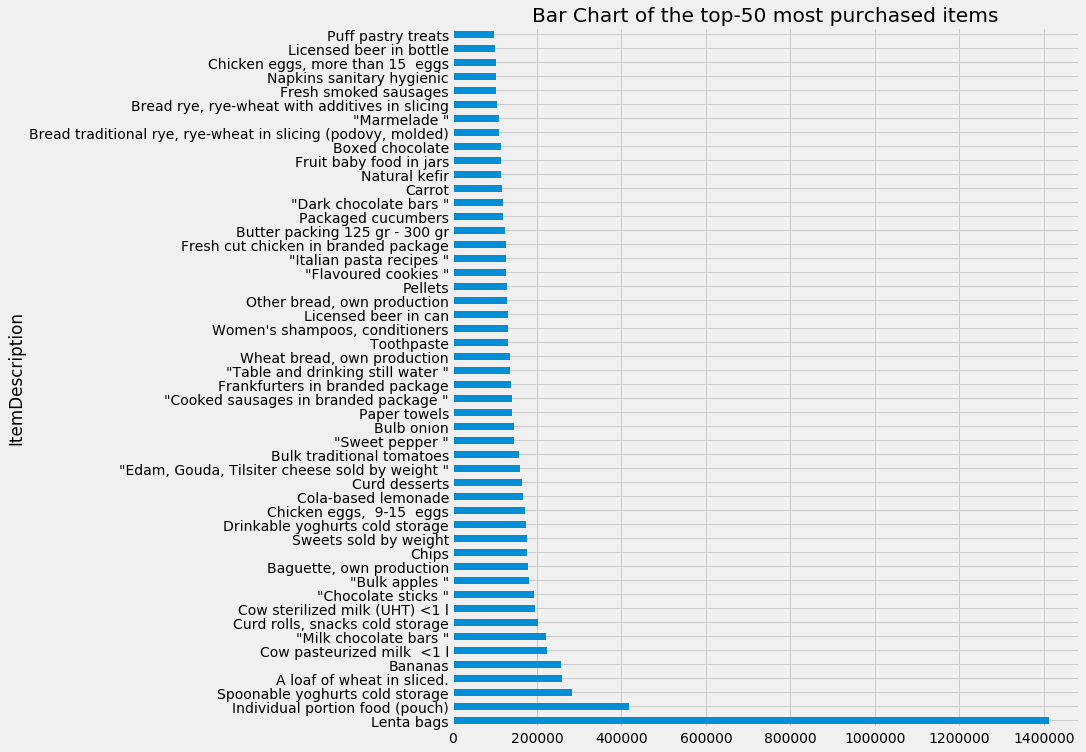

In [730]:
plt.figure(figsize=(10,12))
plt.title('Bar Chart of the top-50 most purchased items')
top_items_qqt.plot.barh()

     -  'Lenta bags' is the most purchased item
 
 
      - Followed by :
  
              'Individual portion food (pouch)',
              'Spoonable yoghurts cold storage', 
              'A loaf of wheat in sliced.',
              'Bananas'...

In [724]:
# b = df[['vendor','SalesCount']]
# b['vendor'] = b['vendor'].dropna()
# b['vendor'] =  b['vendor'].astype(str)

In [725]:
#b['vendor'].dtype

In [723]:
#                  ##getting most popular vendors by item quantities...                               
# vendor_items_qqt = b.groupby(['vendor'])['SalesCount'].count().sort_values(ascending=False)[:50]   
# vendor_items_qqt.index.values

In [677]:
df['ItemPrice'].nunique()

162996

In [670]:
percent_below_800Rubles = 100*(len(pos_price_df[pos_price_df['ItemPrice'] < 800])/len(pos_price_df['ItemPrice']))
print('% of items below 800Rubles: ', percent_below_800Rubles)

% of items below 800Rubles:  98.87524826771059


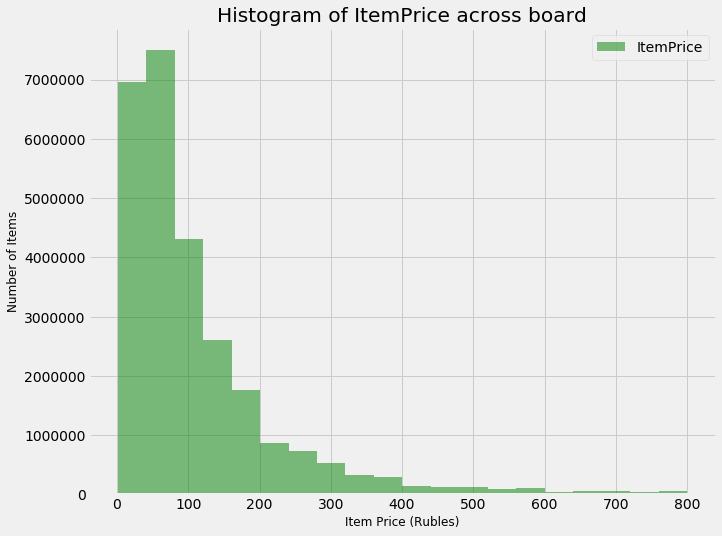

In [662]:
#..........
plt.figure(figsize=(10,8))
pos_price_df['ItemPrice'].plot.hist(alpha=0.5,color='g',bins=20,range = (1,800))
plt.legend(['ItemPrice'])
plt.title('Histogram of ItemPrice across board')
plt.ylabel('Number of Items', fontsize=12)
plt.xlabel('Item Price (Rubles)', fontsize=12)
plt.show()

        - More than 98% of the items have their price range below 800rubles
        
        - Majority of the items are between 0-100rubles

In [731]:
        #Distribution of the item classes
pos_price_df['Class'].value_counts(normalize= True)*100

FOOD        77.227541
NON FOOD    22.618608
NONSALES     0.153851
Name: Class, dtype: float64

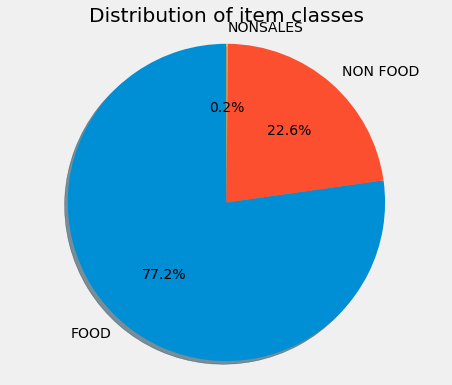

In [732]:
plt.figure(figsize=(7,6))
sizes_=[77.220233, 22.625904,0.153863]
plt.pie(sizes_,
        labels=['FOOD','NON FOOD','NONSALES'],
        startangle=90,
        shadow=True,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of item classes')
plt.show()

In [807]:
#trx_df.head()

In [13]:
pos_price_df.head()

,CardHolder,Material,SalesCount,ItemPrice,net_weight,SubCategorycode,ItemDescription,Class,rpa_wgh2,rpa_wgh2_SubClass,rpa_wgh3,rpa_wgh3_SubClass,vendor
0,10008254,109900,3.0,20.97,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
1,10011935,109900,1.0,6.49,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
2,10036221,109900,3.0,19.47,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
3,10036221,109900,2.0,12.98,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0
4,10036221,109900,4.0,25.96,23.0,401201,Lenta bags,NON FOOD,40.0,"""Household cleaning products """,4012.0,Packaging and containers,100260.0


In [738]:
                        #extracting unique negative price list
unique_item_list = list(pos_price_df['Material'].unique())
len(unique_item_list)

58326

In [743]:
trx_df['Material'] = trx_df['Material'].astype(int)
trx_df['Material'].dtype

dtype('int64')

In [745]:
callday_df = trx_df.loc[trx_df['Material'].isin(unique_item_list)]
callday_df = callday_df.drop(['ChequeId','Discount','Subcategory'],axis=1)
callday_df.head()

,CardHolder,CALDAY,SalesCount,SalesSumma,Material
0,10008254,20200130,3.000,20.97,109900
1,10008254,20200130,1.000,169.99,439630
2,10008254,20200130,1.000,198.49,429670
3,10008254,20200130,1.000,348.99,152314
4,10008254,20200130,1.000,79.99,81107


In [758]:
callday_df['CALDAY'] = pd.to_datetime(callday_df['CALDAY'])
#callday_df['PurchaseMonth'] = callday_df['CALDAY'].dt.month
#callday_df = callday_df.drop(['PurchaseMonth'],axis=1)
callday_df['PurchaseMonthYear'] = pd.to_datetime(callday_df['CALDAY']).dt.to_period('M')
callday_df.head(3)

,CardHolder,CALDAY,SalesCount,SalesSumma,Material,PurchaseMonthYear
0,10008254,2020-01-30,3.000,20.97,109900,2020-01
1,10008254,2020-01-30,1.000,169.99,439630,2020-01
2,10008254,2020-01-30,1.000,198.49,429670,2020-01


In [759]:
used_dt = callday_df[(callday_df['CALDAY'] >= '2019-01-01')]

In [774]:
sample = used_dt.tail(20)

In [809]:
#sample['SalesCount'] = sample['SalesCount'].astype(float)
#sample.groupby(["PurchaseMonthYear"]).agg({'SalesCount':'sum'}).reset_index()
#sample.groupby(['PurchaseMonthYear']).sum()

In [795]:
used_dt['SalesCount'] = used_dt['SalesCount'].astype(float)
dt_item_sum = used_dt.groupby(["PurchaseMonthYear"]).agg({'SalesCount':'sum'}).reset_index()
dt_item_sum

,PurchaseMonthYear,SalesCount
0,2019-01,1361433.977
1,2019-02,1376454.219
2,2019-03,1599027.421
3,2019-04,1402169.223
4,2019-05,1285540.772
5,2019-06,1159831.056
6,2019-07,1042722.142
7,2019-08,1161181.043
8,2019-09,1311989.013
9,2019-10,1203245.534


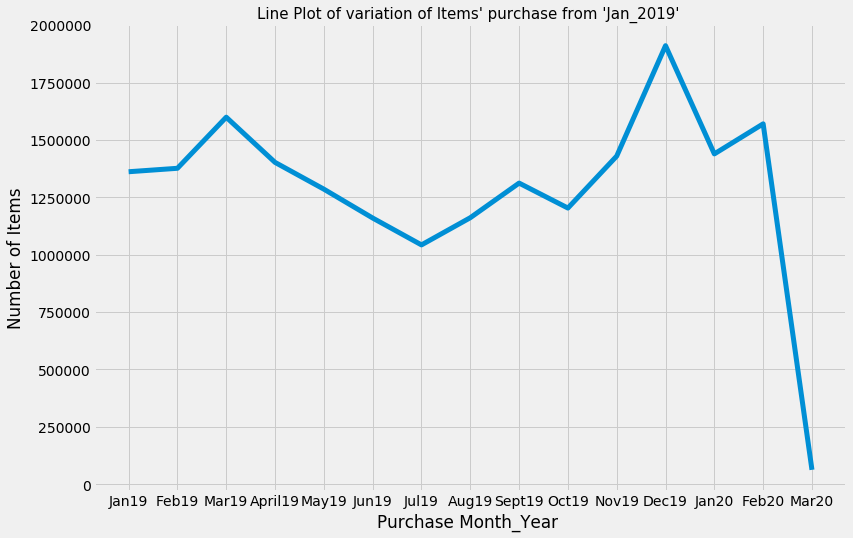

In [810]:
plt.figure(figsize=(12,8))
x =  ['Jan19','Feb19','Mar19','April19','May19','Jun19',
      'Jul19','Aug19','Sept19','Oct19','Nov19','Dec19',
     'Jan20','Feb20','Mar20']
y =  dt_item_sum['SalesCount']
plt.plot(x, y, linewidth=5, markersize=12)
plt.title("Line Plot of variation of Items' purchase from 'Jan_2019' ", fontsize=15)
plt.ylabel('Number of Items')
plt.xlabel('Purchase Month_Year ')
plt.show()